In [1]:
import bsm2smeft # Matching of UV models to SMEFT
import warnings # Disable some persistent warnings from flavio
from tqdm import tqdm # Progress bars
import wilson # EFT Wilson coefficients
from wilson import Wilson
import flavio # Flavour observables in EFTs
import numpy as np # Linear algebra
from functools import partial # Define functions with some frozen arguments
import mlinoe # ML stuff
import matplotlib.pyplot as plt # plotting
plt.rcParams.update({'text.usetex':True})

# Part 1: Preparing the training data

We study BSM models that can match at tree level to semileptonic 4-fermion SMEFT operators. We follow the notation of [1711.10391](https://arxiv.org/abs/1711.10391)

In [2]:
models: list[bsm2smeft.common.Field] = [
    bsm2smeft.scalars.phi,
    bsm2smeft.scalars.omega1,
    bsm2smeft.scalars.omega4,
    bsm2smeft.scalars.Pi1,
    bsm2smeft.scalars.Pi7,
    bsm2smeft.scalars.zeta,
    bsm2smeft.vectors.B,
    bsm2smeft.vectors.W,
    bsm2smeft.vectors.U2,
    bsm2smeft.vectors.Q5,
    bsm2smeft.vectors.X
]

And for the moment, only 5 observables

In [3]:
observables_toymodel = ['BR(B+->Knunu)', ('<dBR/dq2>(B+->Kmumu)', 1.1, 6.0), 'BR(B0->Dtaunu)', ('<Rmue>(B+->Kll)', 1.1, 6.0), 'Rtaul(B->Dlnu)']

In order to speed up things, we pre-compute the running from the SMEFT to the B-physics scale.

In [4]:
wc_wet = {}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for m in tqdm(models):
        b = m(1000, 1000)
        for c in b.couplings:
            c.universal(1.0)
        wmatch = b.match()
        for coeff in wmatch.wc.values.keys():
            if coeff not in wc_wet.keys():
                wc_wet |= {coeff: Wilson({coeff: 1e-6}, basis='Warsaw', eft='SMEFT', scale=1e3).match_run(scale=4.8, basis='flavio', eft='WET')}

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:03<00:00,  5.76s/it]


In [5]:
def combine_wet(wcs: list[Wilson], factors: list[float|complex]) -> Wilson:
    '''
    Calculates a linear combination of WET Wilson coefficients 
    '''
    coeffs = {}
    for wc in wcs:
        coeffs = coeffs | {c: 0 for c in wc.values.keys()}
    for wc, f in zip(wcs, factors):
        for k, v in wc.values.items():
            if isinstance(v, float):
                coeffs[k] += f*wc.values[k]
            else:
                coeffs[k] += f*(wc.values[k]['Re'] + 1j*wc.values[k]['Im'])
    return Wilson(coeffs, scale=4.8, basis='flavio', eft='WET')

def dict2complex(x: float | dict[str, float]) -> complex:
    if isinstance(x, dict):
        return x['Re']+1j*x['Im']
    else:
        return x

The `f_model`'s compute the observables as a function of the parameters of each model. These functions are then wrapped in a `mlinoe.Model` object, taht checks that there are no missing parameters or observables, and prepares por parallelization.

In [6]:
mlinoe_models = []

def f_model(pars, m):
    m0 = m(1000, 1000)
    couplings = m0.couplings
    for i, ct in enumerate([c.tex for c in couplings]):
        m0.couplings[i].universal(pars[ct])

    wmatch = m0.match()
    # Running of the Wilson coefficients calculated using the pre-computed values
    w_b = combine_wet([wc_wet[coeff] for coeff in wmatch.wc.values.keys()], [dict2complex(wmatch.wc.values[coeff])/1e-6 for coeff in wmatch.wc.values.keys()])
    obs_val = {}
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for obs in observables_toymodel:
            if isinstance(obs, tuple):
                obs_val |= {str(obs): flavio.np_prediction(obs[0], w_b, *obs[1:])}
            else:
                obs_val |= {obs: flavio.np_prediction(obs, w_b)}
    return obs_val

for m in models:
    m0 = m(1000, 1000)
    couplings = m0.couplings

    sanitized_tex = m0.tex.replace("\\", "").replace(r'{', '').replace(r'}', '')

    # This is a little trick: in order to parallelize and send each coupling to a different core, python requires a function that is pickable (so no a lambda), and has a unique name. In order to create such functions inside a loop, we have to directly mess with locals(), which is a dict that contains all the variables thar are currently defined
    locals()[f'f_{sanitized_tex}'] = partial(f_model, m=m)
    mlinoe_models.append(mlinoe.Model(m0.tex, [c.tex for c in couplings], [str(obs) for obs in observables_toymodel], locals()[f'f_{sanitized_tex}']))

We also include the SM predictions (with no free parameters)

In [7]:
sm_values = {}
sm_uncert = {}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for obs in observables_toymodel:
        if isinstance(obs, str):
            sm_values |= {obs: flavio.sm_prediction(obs)}
            sm_uncert |= {obs: flavio.sm_uncertainty(obs)}     
        else:
            sm_values |= {str(obs): flavio.sm_prediction(*obs)}
            sm_uncert |= {str(obs): flavio.sm_uncertainty(*obs)}   

In [8]:
def f_SM(pars):
    obs_val = {}
    for obs in observables_toymodel:
        obs_val |= {str(obs): float(sm_values[str(obs)] + np.random.normal()*sm_uncert[str(obs)])}
    return obs_val

mlinoe_models.append(mlinoe.classes.Model("SM", [], [str(obs) for obs in observables_toymodel], f_SM))

and finally we compute the training dataset. For the toy model, we impose that the couplings are flavour-universal, and are generated according to
$$g = s \times 10^u$$
where $s$ is randomly chosen in $\{-1, +1\}$, and $u\sim \mathcal{N}(0,1)$ is distributed normally.

In [9]:
N_points = 1000

for mm in mlinoe_models:
    couplings = [{c: (2*np.random.randint(0, 2)-1)*10**np.random.normal() for c in mm.parameters} for _ in range(N_points)]
    mm.batch_save(couplings, 'toymodel', 10)

The datasets include the parameters used in each iteration, the observables and the model.

# Part 2: Machine Learning

We have implemented a classifier based on `xgboost`, a boosted decision/regression tree algorithm.

The prediction of the algorithm is an array of numbers, whose length is the total number of models included in the training dataset. These numbers are in $[0, 1)$, and their sum is 1, and can be interpreted as the probability asigned by the algorithm for the input corresponding to each model.

In [10]:
xc1 = mlinoe.XClassifier.from_dataset('toymodel', model_pars={'n_estimators': 20, 'tree_method':'approx'})

In [11]:
xc1.train()

Once we have trained the algorithm, some diagnostics run on the test sub-dataset:
- precision is the proportion of points identified as corresponding to the model which have actually been generated by the model.
- recall is the proportion of pointsgenerated by the model which have actually been identified correctly.
- $f_1 = 2\frac{\mathrm{precision}\times\mathrm{recall}}{\mathrm{precision}+\mathrm{recall}}$

In [12]:
xc1.report()

               precision    recall  f1-score   support

           SM       0.99      1.00      0.99       298
        \Pi_1       0.99      0.99      0.99       274
        \Pi_7       0.96      0.79      0.87       301
  \mathcal{B}       0.95      0.77      0.85       295
\mathcal{Q}_5       0.97      0.86      0.91       310
\mathcal{U}_2       0.91      0.85      0.88       308
  \mathcal{W}       0.84      0.96      0.90       298
  \mathcal{X}       0.84      0.91      0.88       298
     \omega_1       0.85      1.00      0.92       305
     \omega_4       0.95      1.00      0.98       336
      \varphi       0.87      0.93      0.90       296
        \zeta       0.98      1.00      0.99       281

     accuracy                           0.92      3600
    macro avg       0.93      0.92      0.92      3600
 weighted avg       0.93      0.92      0.92      3600



Confusion matrix: the entry in the $i$-th row and $j$-th column indicates the number of samples that actually belong to $i$ and have been predicted as $j$.

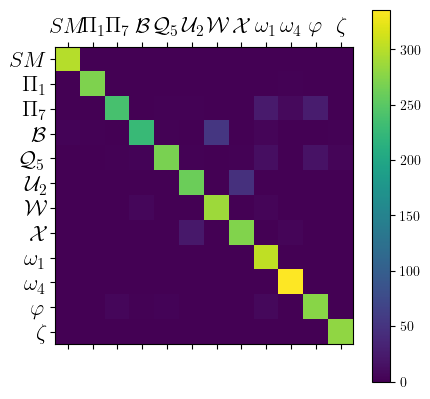

In [13]:
xc1.confusion()

Now let us see the method in action: we input the experimental values to the classifier and see which model, according to the classifier, describes better the data. We check two experimental situations: before 2023, when there was an anomaly in $R_K$, and after 2023, without anomaly

In [14]:
exp_old = {k: v for k, v in zip(['BR(B+->Knunu)', "('<dBR/dq2>(B+->Kmumu)', 1.1, 6.0)", 'BR(B0->Dtaunu)', "('<Rmue>(B+->Kll)', 1.1, 6.0)", 'Rtaul(B->Dlnu)'], [1.3e-5, 2.42e-8, 0.0105, 0.846, 0.344])}
exp_new = {k: v for k, v in zip(['BR(B+->Knunu)', "('<dBR/dq2>(B+->Kmumu)', 1.1, 6.0)", 'BR(B0->Dtaunu)', "('<Rmue>(B+->Kll)', 1.1, 6.0)", 'Rtaul(B->Dlnu)'], [1.3e-5, 2.42e-8, 0.0105, 0.949, 0.344])}

unc_old = {k: v for k, v in zip(['BR(B+->Knunu)', "('<dBR/dq2>(B+->Kmumu)', 1.1, 6.0)", 'BR(B0->Dtaunu)', "('<Rmue>(B+->Kll)', 1.1, 6.0)", 'Rtaul(B->Dlnu)'], [0.4e-5, (0.07**2+0.12**2)**0.5*1e-8, 0.0023, 0.044, 0.026])}
unc_new = {k: v for k, v in zip(['BR(B+->Knunu)', "('<dBR/dq2>(B+->Kmumu)', 1.1, 6.0)", 'BR(B0->Dtaunu)', "('<Rmue>(B+->Kll)', 1.1, 6.0)", 'Rtaul(B->Dlnu)'], [0.4e-5, (0.07**2+0.12**2)**0.5*1e-8, 0.0023, (0.042**2+0.022**2)**0.5, 0.026])}

Prediction for the central values

In [15]:
prob_old = xc1.predict_prob_dict(exp_old)
prob_new = xc1.predict_prob_dict(exp_new)

and inside the error margin

In [16]:
probunc_old = []
probunc_new = []
for _ in range(500):
    val_old = {k: exp_old[k] + np.random.normal()*unc_old[k] for k in exp_old.keys()}
    val_new = {k: exp_new[k] + np.random.normal()*unc_new[k] for k in exp_new.keys()}
    probunc_old.append(xc1.predict_prob_dict(val_old))
    probunc_new.append(xc1.predict_prob_dict(val_new))

In [17]:
q1_old = np.quantile(probunc_old, 0.2, axis=0)
q9_old = np.quantile(probunc_old, 0.8, axis=0)

q1_new = np.quantile(probunc_new, 0.2, axis=0)
q9_new = np.quantile(probunc_new, 0.8, axis=0)

The error bars correspond to the probabilty intervals between percentile 20 and percentile 80

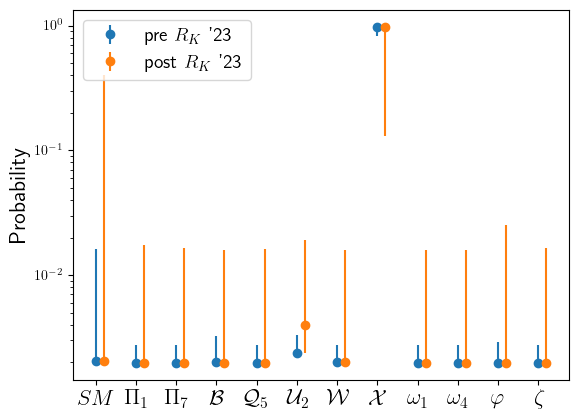

In [18]:
plt.errorbar(range(len(prob_old)), prob_old, [prob_old-q1_old, q9_old-prob_old], label=r"pre $R_K$ '23", fmt='o')
plt.errorbar(np.array(range(len(prob_new)))+0.2, prob_new, [prob_new-q1_new, q9_new-prob_new], label=r"post $R_K$ '23", fmt='o')
ax = plt.gca()
ax.set_yscale('log')
plt.xticks(range(len(xc1.labels)), [f'${l}$' for l in xc1.labels], fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.legend(fontsize=14)

The preferred model is the vector leptoquark $\mathcal{X}\sim (3, 3)_{2/3}$ (aka $U_3$), followed by $\mathcal{U}_2 \sim (3, 1)_{2/3}$ (aka $U_1$)

$$\mathcal{L} = \sum_i\left( g_{\mathcal{U}_2}^{ed} \mathcal{U}_2^{\mu\dagger}\bar{e}_{Ri}\gamma_\mu d_{Ri} + g_{\mathcal{U}_2}^{\ell q} \mathcal{U}_2^{\mu\dagger}\bar{\ell}_{Li}\gamma_\mu q_{Li}+\frac{1}{2}g_\mathcal{X}\mathcal{X}^{\mu\dagger}_a \bar{\ell}_{Li}\gamma_\mu \sigma^a q_{Li} + \mathrm{h.c.} \right)$$